# MARS Air Temperature and Pressure Prediction

This notebook was made for predicting the air temperature and Pressure for the next 2 years in Mars

In [273]:
import warnings
warnings.filterwarnings("ignore")
%pip install seaborn numpy matplotlib --upgrade

In [274]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Set the Seaborn color palette and style
sns.set_style("whitegrid")

## Exploratory Analysis

In [275]:
df = pd.read_csv('REMS_Mars_Dataset.csv')

We can notice that we have two different numbers for air temperature. Our target is going to be calculated based on the average air temperature (max and min).

In [276]:
df.head()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
0,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
1,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
2,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,Value not available,Value not available,05:25,17:21,moderate,Sunny
3,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,Value not available,Value not available,05:26,17:21,moderate,Sunny
4,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,Value not available,Value not available,05:26,17:21,moderate,Sunny


Almost all information is in Object type. We need to transform that.

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   earth_date_time      3197 non-null   object
 1   mars_date_time       3197 non-null   object
 2   sol_number           3197 non-null   object
 3   max_ground_temp(°C)  3197 non-null   object
 4   min_ground_temp(°C)  3197 non-null   object
 5   max_air_temp(°C)     3197 non-null   object
 6   min_air_temp(°C)     3197 non-null   object
 7   mean_pressure(Pa)    3197 non-null   object
 8   wind_speed(m/h)      3197 non-null   object
 9   humidity(%)          3197 non-null   object
 10  sunrise              3197 non-null   object
 11  sunset               3197 non-null   object
 12  UV_Radiation         3170 non-null   object
 13  weather              3197 non-null   object
dtypes: object(14)
memory usage: 349.8+ KB


Extracting information to a datetime column

In [278]:
df['Data_Terra'] = df['earth_date_time'].str.\
                    split(',', expand=True)[1].str.\
                    split(expand=True)[0].astype('datetime64[ns]')

We can notice some missing values in the dataset. Ususally this would appear as Nan, but here it appears as "Value not available". We need to change that in place to transform the types of the numeric values

In [279]:
df.tail()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather,Data_Terra
3192,"Earth, 2012-08-18 UTC","Mars, Month 6 - LS 156°",Sol 12,-18,-76,8,-82,741,Value not available,Value not available,05:28,17:21,very_high,Sunny,2012-08-18
3193,"Earth, 2012-08-17 UTC","Mars, Month 6 - LS 156°",Sol 11,-11,-76,9,-83,740,Value not available,Value not available,05:28,17:21,very_high,Sunny,2012-08-17
3194,"Earth, 2012-08-16 UTC","Mars, Month 6 - LS 155°",Sol 10,-16,-75,8,-83,739,Value not available,Value not available,05:28,17:22,very_high,Sunny,2012-08-16
3195,"Earth, 2012-08-15 UTC","Mars, Month 6 - LS 155°",Sol 9,Value not available,Value not available,Value not available,Value not available,Value not available,Value not available,Value not available,05:28,17:22,NaN,Sunny,2012-08-15
3196,"Earth, 2012-08-07 UTC","Mars, Month 6 - LS 150°",Sol 1,Value not available,Value not available,Value not available,Value not available,Value not available,Value not available,Value not available,05:30,17:22,NaN,Sunny,2012-08-07


In [280]:
df = df.replace('Value not available', np.nan)

Everything ok so far

In [281]:
df.tail()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather,Data_Terra
3192,"Earth, 2012-08-18 UTC","Mars, Month 6 - LS 156°",Sol 12,-18,-76,8,-82,741,NaN,NaN,05:28,17:21,very_high,Sunny,2012-08-18
3193,"Earth, 2012-08-17 UTC","Mars, Month 6 - LS 156°",Sol 11,-11,-76,9,-83,740,NaN,NaN,05:28,17:21,very_high,Sunny,2012-08-17
3194,"Earth, 2012-08-16 UTC","Mars, Month 6 - LS 155°",Sol 10,-16,-75,8,-83,739,NaN,NaN,05:28,17:22,very_high,Sunny,2012-08-16
3195,"Earth, 2012-08-15 UTC","Mars, Month 6 - LS 155°",Sol 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05:28,17:22,NaN,Sunny,2012-08-15
3196,"Earth, 2012-08-07 UTC","Mars, Month 6 - LS 150°",Sol 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05:30,17:22,NaN,Sunny,2012-08-07


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   earth_date_time      3197 non-null   object        
 1   mars_date_time       3197 non-null   object        
 2   sol_number           3197 non-null   object        
 3   max_ground_temp(°C)  3169 non-null   object        
 4   min_ground_temp(°C)  3169 non-null   object        
 5   max_air_temp(°C)     3168 non-null   object        
 6   min_air_temp(°C)     3168 non-null   object        
 7   mean_pressure(Pa)    3170 non-null   object        
 8   wind_speed(m/h)      0 non-null      float64       
 9   humidity(%)          0 non-null      float64       
 10  sunrise              3197 non-null   object        
 11  sunset               3197 non-null   object        
 12  UV_Radiation         3170 non-null   object        
 13  weather              3194 non-nul

We are gonna remove the empty columns and the redundant ones (earth_data_time)

In [283]:
df.drop(columns=['earth_date_time', 'sol_number', 'wind_speed(m/h)', 'humidity(%)', 'mars_date_time'], inplace=True)

We need to transform the numeric values to make a analysis on that

In [284]:
df = df.astype({'max_ground_temp(°C)': 'Int32', 
                'min_ground_temp(°C)':'Int32', 
                'max_air_temp(°C)': 'Int32',
                'min_air_temp(°C)': 'Int32', 
                'mean_pressure(Pa)': 'Int32'})

In [285]:
num_cols = ['max_ground_temp(°C)', 'min_ground_temp(°C)', 'max_air_temp(°C)',
       'min_air_temp(°C)', 'mean_pressure(Pa)']

That's better now! We can see that there are some empty values.

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   max_ground_temp(°C)  3169 non-null   Int32         
 1   min_ground_temp(°C)  3169 non-null   Int32         
 2   max_air_temp(°C)     3168 non-null   Int32         
 3   min_air_temp(°C)     3168 non-null   Int32         
 4   mean_pressure(Pa)    3170 non-null   Int32         
 5   sunrise              3197 non-null   object        
 6   sunset               3197 non-null   object        
 7   UV_Radiation         3170 non-null   object        
 8   weather              3194 non-null   object        
 9   Data_Terra           3197 non-null   datetime64[ns]
dtypes: Int32(5), datetime64[ns](1), object(4)
memory usage: 203.1+ KB


Analyzing the columns we noticed that all of them are continuos mesures. So, the logic is that they probabily follow a pattern. 

Based on that we chosed to use ffill, a method that fills the Nan values with the last read value 

In [287]:
df.ffill(inplace=True)

OK! Now we can calculate our target value

In [288]:
df['Mean_air_temperature'] = (df['max_air_temp(°C)'] + df['min_air_temp(°C)'])/2

In [289]:
df.columns

Index(['max_ground_temp(°C)', 'min_ground_temp(°C)', 'max_air_temp(°C)',
       'min_air_temp(°C)', 'mean_pressure(Pa)', 'sunrise', 'sunset',
       'UV_Radiation', 'weather', 'Data_Terra', 'Mean_air_temperature'],
      dtype='object')

Let's take a look on the behavior of our target with time

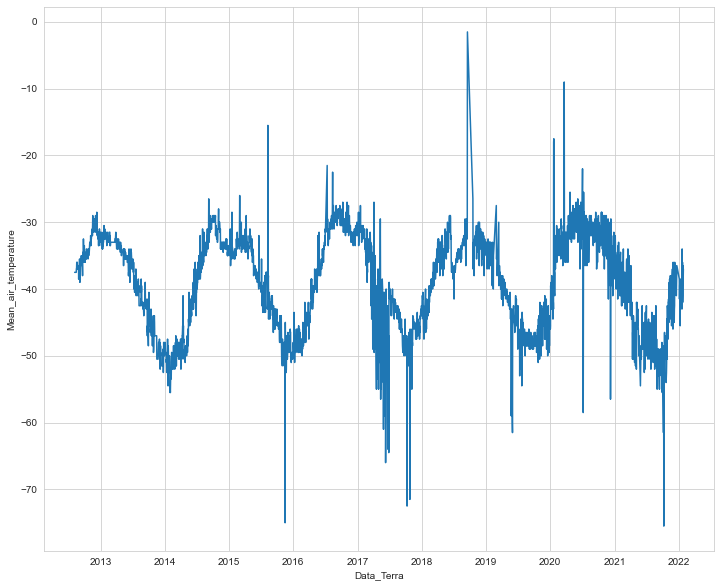

In [290]:
plt.figure(figsize=(12,10))
sns.lineplot(data =df, x = 'Data_Terra', y= 'Mean_air_temperature')
plt.show()

For most of the time, we can notice the seasonality, with some atypical values.

Let's take other look, but for Pressure

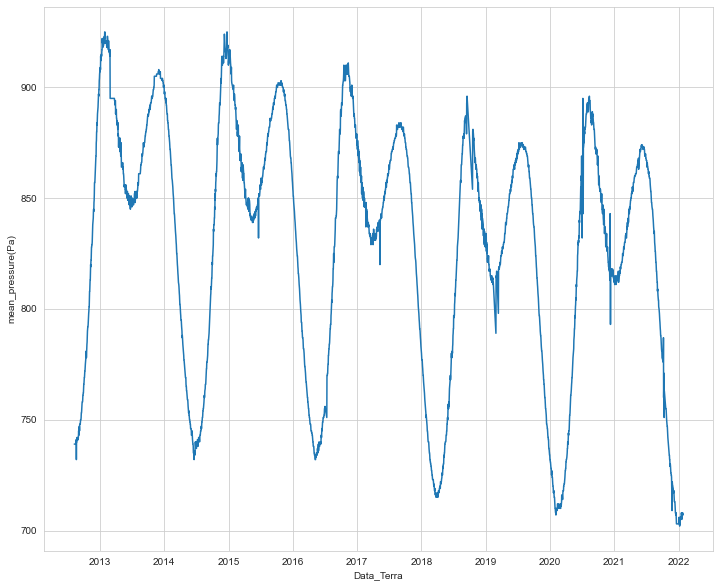

In [291]:
plt.figure(figsize=(12,10))
sns.lineplot(data =df, x = 'Data_Terra', y= 'mean_pressure(Pa)')
plt.show()

We are gonna remove the max and min air temperature. Its not necessary any more.

In [292]:
df.drop(['max_air_temp(°C)', 'min_air_temp(°C)'], axis = 1, inplace=True)

Set the date as the index

In [293]:
df.head()

,max_ground_temp(°C),min_ground_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation,weather,Data_Terra,Mean_air_temperature
0,-3,-71,707,05:25,17:20,moderate,Sunny,2022-01-26,-37.0
1,-3,-72,707,05:25,17:20,moderate,Sunny,2022-01-25,-38.5
2,-4,-70,708,05:25,17:21,moderate,Sunny,2022-01-24,-36.5
3,-6,-70,707,05:26,17:21,moderate,Sunny,2022-01-23,-41.0
4,-7,-71,708,05:26,17:21,moderate,Sunny,2022-01-22,-42.0


In [294]:
df.index = df['Data_Terra']
df.drop(['Data_Terra', 'sunrise', 'sunset', 'weather'], inplace=True, axis = 1)

In [295]:
df.head()

,max_ground_temp(°C),min_ground_temp(°C),mean_pressure(Pa),UV_Radiation,Mean_air_temperature
Data_Terra,,,,,
2022-01-26,-3,-71,707,moderate,-37.0
2022-01-25,-3,-72,707,moderate,-38.5
2022-01-24,-4,-70,708,moderate,-36.5
2022-01-23,-6,-70,707,moderate,-41.0
2022-01-22,-7,-71,708,moderate,-42.0


## Feature vs Target Relationship

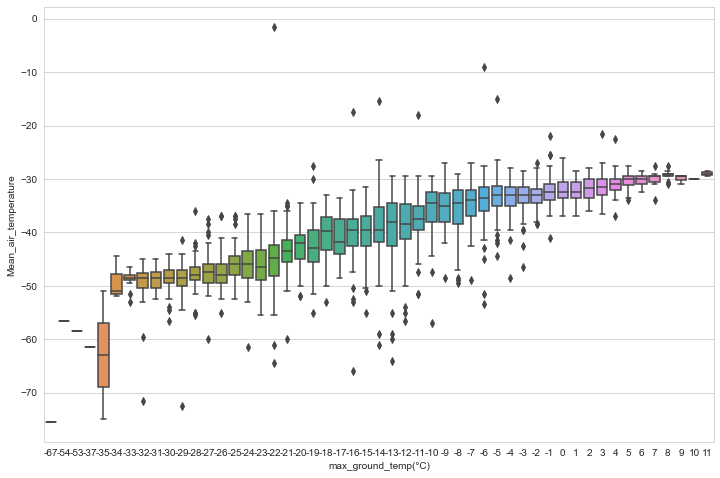

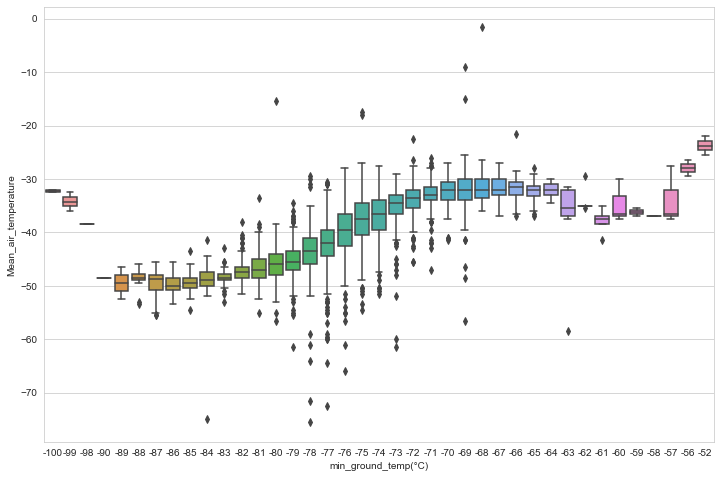

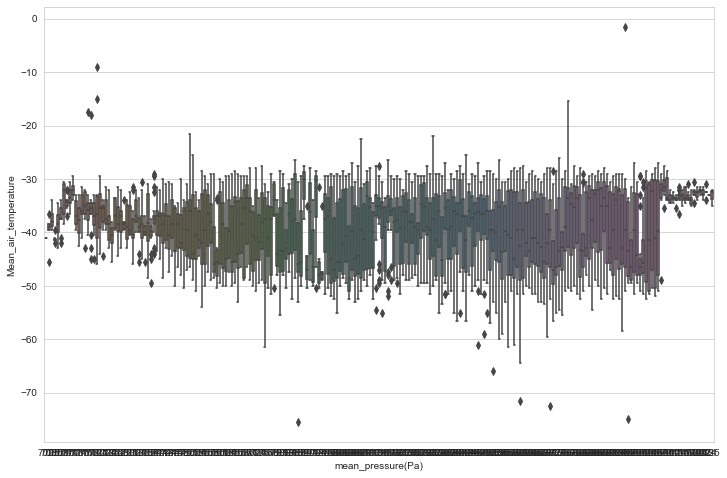

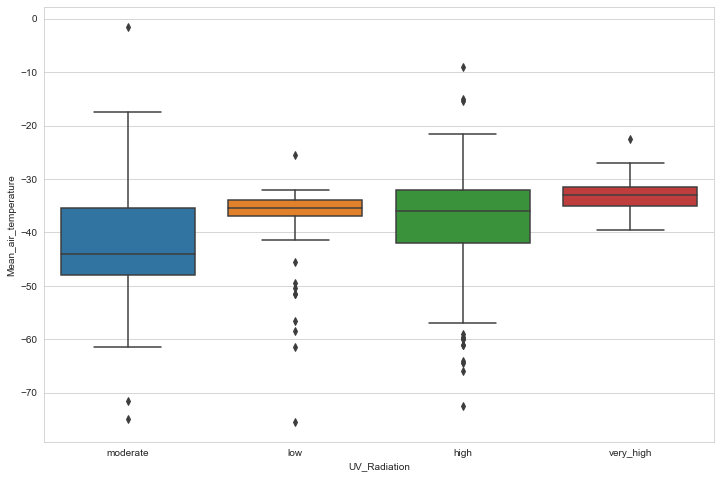

In [296]:
for col in list(df.columns) :
    if col != 'Mean_air_temperature':
        plt.figure(figsize = (12,8))
        sns.boxplot(data = df, y = 'Mean_air_temperature', x = col)
        plt.show() 

It looks like the temperature on the ground and UV_radiation level really influences the air temperature. We can also notice that there is only on weather option (Sunny, of course)

## Model A

First of all. If we intend to use the categories we need to normalize that

In [297]:
df = pd.get_dummies(df, 'UV_Radiation', dtype=int)

In [298]:
df.head()

,max_ground_temp(°C),min_ground_temp(°C),mean_pressure(Pa),Mean_air_temperature,UV_Radiation_high,UV_Radiation_low,UV_Radiation_moderate,UV_Radiation_very_high
Data_Terra,,,,,,,,
2022-01-26,-3,-71,707,-37.0,0,0,1,0
2022-01-25,-3,-72,707,-38.5,0,0,1,0
2022-01-24,-4,-70,708,-36.5,0,0,1,0
2022-01-23,-6,-70,707,-41.0,0,0,1,0
2022-01-22,-7,-71,708,-42.0,0,0,1,0


We are gonna build the first model based only in the features that we have inside of the dataset.

The first thing is to split the data into train and test set

In [299]:
train = df[df.index <= '01/01/2020']
test = df[df.index > '01/01/2020']

Chosing the columns for the model

In [300]:
cols = ['max_ground_temp(°C)', 'min_ground_temp(°C)', 'mean_pressure(Pa)', 'UV_Radiation_high', 'UV_Radiation_low', 'UV_Radiation_moderate',  'UV_Radiation_very_high']
target = ['Mean_air_temperature']

In [301]:
x_train = train[cols]
y_train = train[target]

x_test = test[cols]
y_test = test[target]

In [302]:
x_train.shape, x_test.shape

((2495, 7), (702, 7))

In [303]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2495 entries, 2020-01-01 to 2012-08-07
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   max_ground_temp(°C)     2495 non-null   Int32
 1   min_ground_temp(°C)     2495 non-null   Int32
 2   mean_pressure(Pa)       2495 non-null   Int32
 3   UV_Radiation_high       2495 non-null   int32
 4   UV_Radiation_low        2495 non-null   int32
 5   UV_Radiation_moderate   2495 non-null   int32
 6   UV_Radiation_very_high  2495 non-null   int32
dtypes: Int32(3), int32(4)
memory usage: 95.0 KB


In [304]:
x_train.head()

,max_ground_temp(°C),min_ground_temp(°C),mean_pressure(Pa),UV_Radiation_high,UV_Radiation_low,UV_Radiation_moderate,UV_Radiation_very_high
Data_Terra,,,,,,,
2020-01-01,-13,-76,732,0,0,1,0
2019-12-31,-17,-76,734,0,0,1,0
2019-12-30,-20,-77,734,0,0,1,0
2019-12-29,-17,-76,735,0,0,1,0
2019-12-28,-18,-76,736,0,0,1,0


In [305]:
x_train = x_train.astype('int')
y_train = y_train.astype('int')

x_test = x_test.astype('int')
y_test = y_test.astype('int')


Training the baseline model. For this we are going to use the XGBRegressor

In [306]:
rg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50)
rg.fit(x_train, y_train, verbose=True)


[17:40:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(early_stopping_rounds=50, n_estimators=1000)

Let's predict based on the test dataset and see the mse

In [307]:
y_pred = rg.predict(x_test)

In [308]:
mse = mean_squared_error(y_pred, y_test)
mse

16.340061418787737

Let's plot the values

In [309]:
y_pred = pd.DataFrame(y_pred, index = y_test.index)

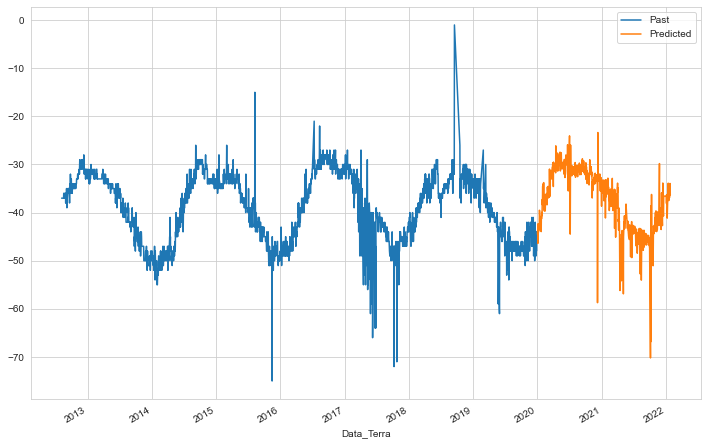

In [310]:
fig, ax = plt.subplots(figsize=(12, 8))
y_train.plot(ax = ax)
y_pred.plot(ax = ax)
plt.legend(['Past', 'Predicted'])
plt.show()

Let's compare with the real values

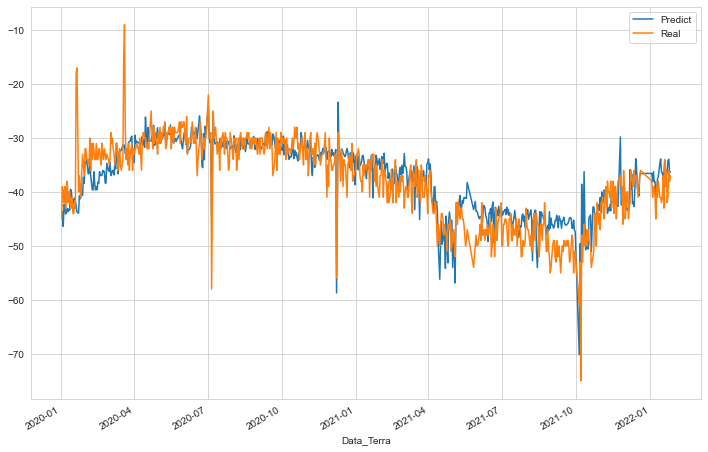

In [311]:
fig, ax = plt.subplots(figsize=(12, 8))
y_pred.plot(ax = ax)
y_test.plot(ax = ax)
plt.legend(['Predict', 'Real'])
plt.show()

Let's see the residual values

In [312]:
y_test

,Mean_air_temperature
Data_Terra,
2022-01-26,-37
2022-01-25,-38
2022-01-24,-36
2022-01-23,-41
2022-01-22,-42
...,...
2020-01-06,-39
2020-01-05,-42
2020-01-04,-40


In [313]:
error = y_test['Mean_air_temperature'] - y_pred[0]

In [314]:
error

Data_Terra
2022-01-26   -0.712215
2022-01-25   -1.678379
2022-01-24   -2.059143
2022-01-23   -6.805378
2022-01-22   -5.708492
                ...   
2020-01-06    3.797646
2020-01-05    0.323479
2020-01-04    6.392159
2020-01-03    4.672897
2020-01-02   -0.524380
Length: 702, dtype: float64

<Axes: xlabel='Data_Terra'>

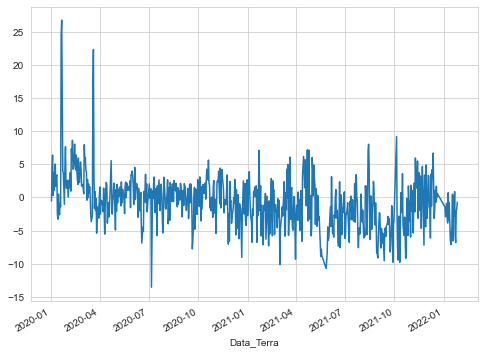

In [315]:
plt.figure(figsize = (8,6))
error.plot()

It looks very well distributed.

<Axes: >

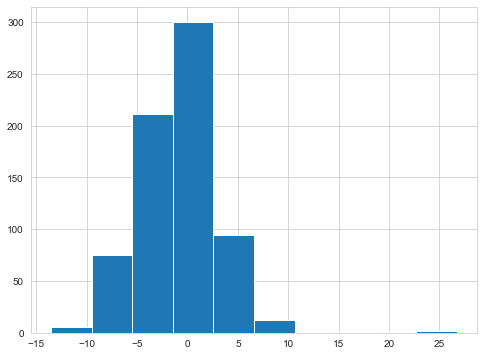

In [316]:
plt.figure(figsize = (8,6))
error.hist()

#### Feature Importance

In [317]:
FI = pd.DataFrame(rg.feature_importances_, 
index = rg.get_booster().feature_names,
columns = ['Importance'])

<Axes: title={'center': 'Feature Importance'}>

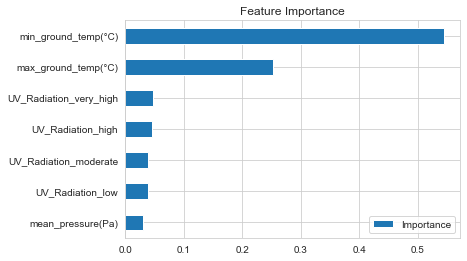

In [318]:
FI.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance')

### Pressure prediction

lets do the same for Pressure

In [319]:
cols = ['max_ground_temp(°C)', 'min_ground_temp(°C)','UV_Radiation_high', 'UV_Radiation_low', 'UV_Radiation_moderate',  'UV_Radiation_very_high', 'Mean_air_temperature']
target = ['mean_pressure(Pa)']

In [320]:
x_train = train[cols]
y_train = train[target]

x_test = test[cols]
y_test = test[target]

x_train = x_train.astype('int')
y_train = y_train.astype('int')

x_test = x_test.astype('int')
y_test = y_test.astype('int')


rg = xgb.XGBRegressor(n_estimators=1000)
rg.fit(x_train, y_train, verbose=True)


y_pred =rg.predict(x_test)

mse = mean_squared_error(y_pred, y_test)
print(mse)


y_pred = pd.DataFrame(y_pred, index = y_test.index)

[17:40:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


5659.134529658506


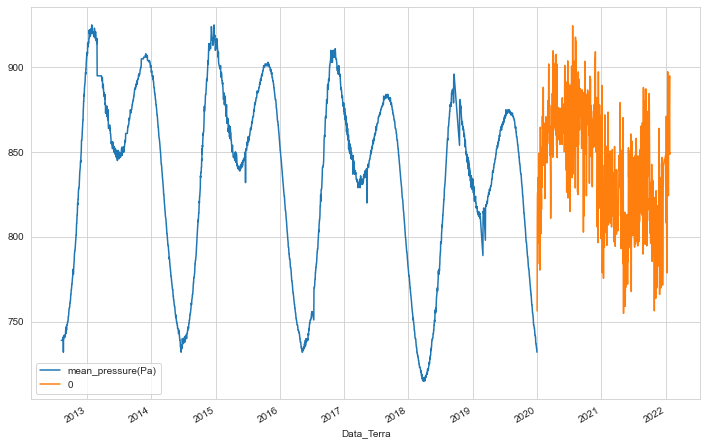

In [321]:
fig, ax = plt.subplots(figsize=(12, 8))
y_train.plot(ax = ax)
y_pred.plot(ax = ax)
plt.show()

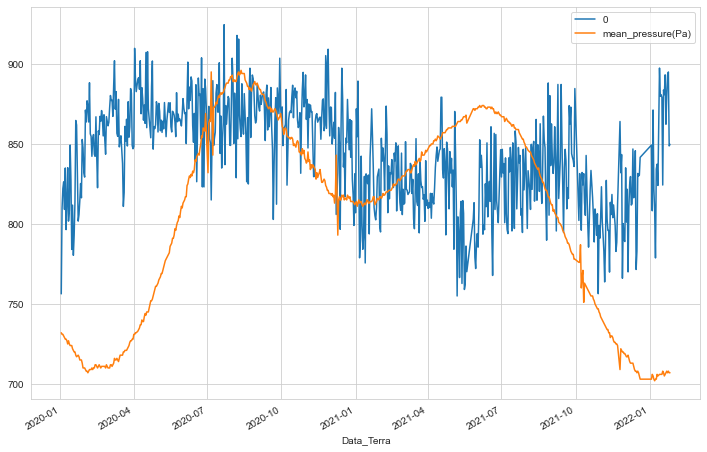

In [322]:
fig, ax = plt.subplots(figsize=(12, 8))
y_pred.plot(ax = ax)
y_test.plot(ax = ax)
plt.show()

Ok! Thats was way worst for the Pressure. It seems that we can not use our fatures for Pressure. Let's try another way

#### Feature Importance

In [323]:
FI = pd.DataFrame(rg.feature_importances_, 
index = rg.get_booster().feature_names,
columns = ['Importance'])

<Axes: title={'center': 'Feature Importance'}>

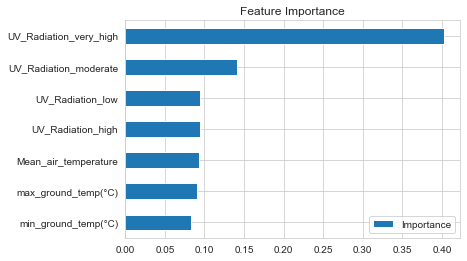

In [324]:
FI.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance')

# Model B

Let's try to use the features from date to extract seasonality behavior

In [325]:
def cria_var(df):
    df['dia_semana'] = df.index.dayofweek
    df['quarter'] = df.index.quarter    
    df['mes'] = df.index.month
    df['ano'] = df.index.year
    df['dia_ano'] = df.index.dayofyear
    return df
        

In [326]:
train = cria_var(train)
test = cria_var(test)

In [327]:
train.head()

,max_ground_temp(°C),min_ground_temp(°C),mean_pressure(Pa),Mean_air_temperature,UV_Radiation_high,UV_Radiation_low,UV_Radiation_moderate,UV_Radiation_very_high,dia_semana,quarter,mes,ano,dia_ano
Data_Terra,,,,,,,,,,,,,
2020-01-01,-13,-76,732,-46.0,0,0,1,0,2,1,1,2020,1
2019-12-31,-17,-76,734,-44.0,0,0,1,0,1,4,12,2019,365
2019-12-30,-20,-77,734,-45.5,0,0,1,0,0,4,12,2019,364
2019-12-29,-17,-76,735,-45.0,0,0,1,0,6,4,12,2019,363
2019-12-28,-18,-76,736,-45.5,0,0,1,0,5,4,12,2019,362


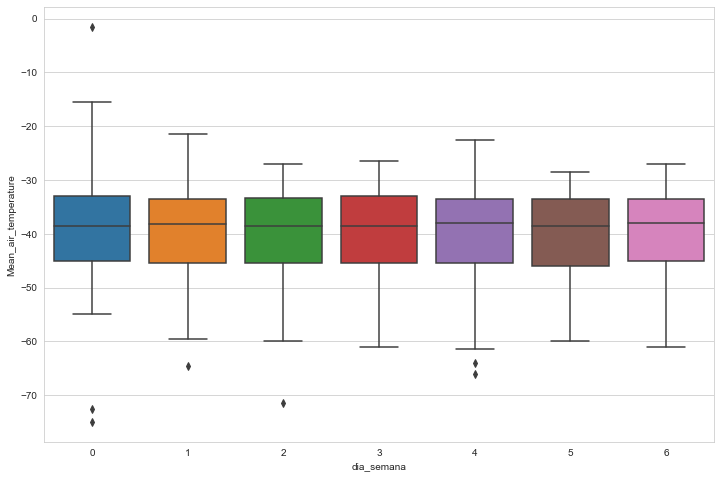

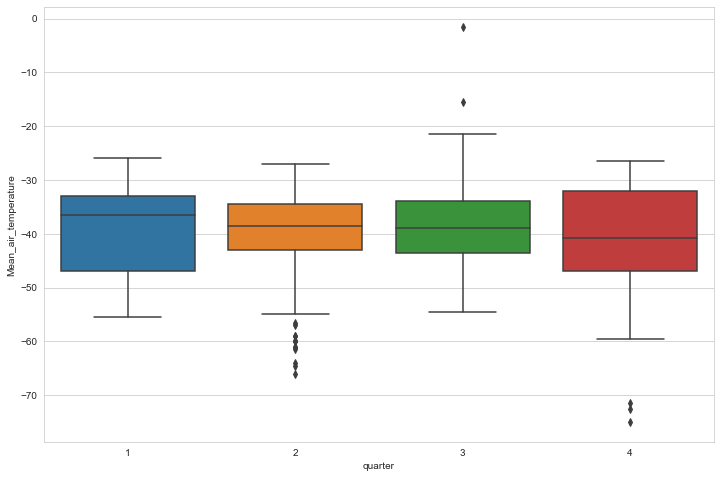

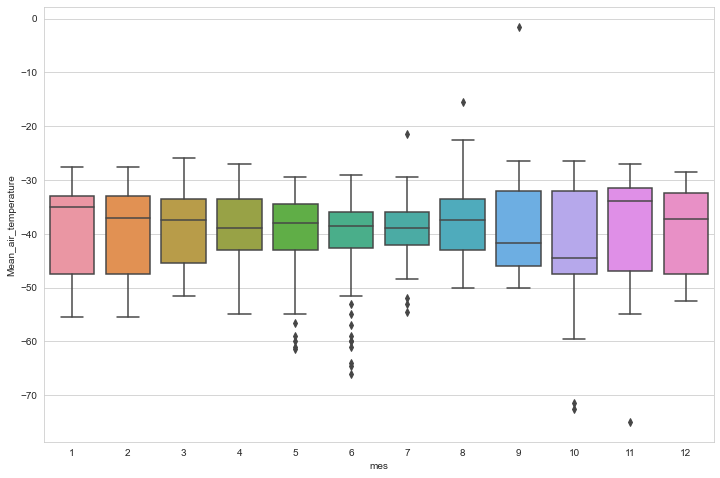

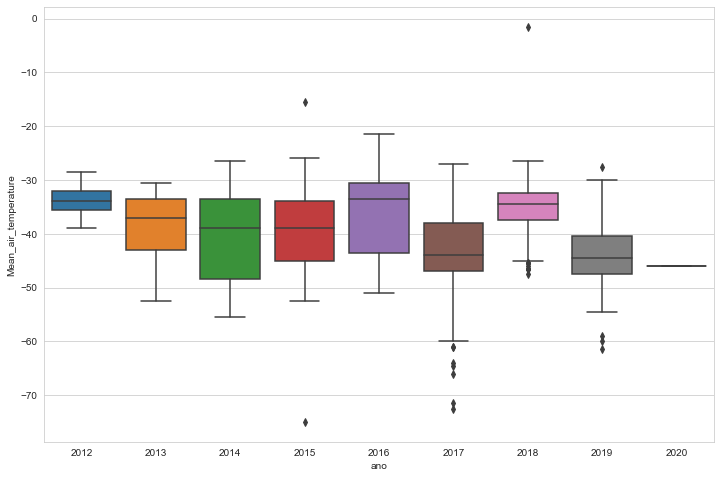

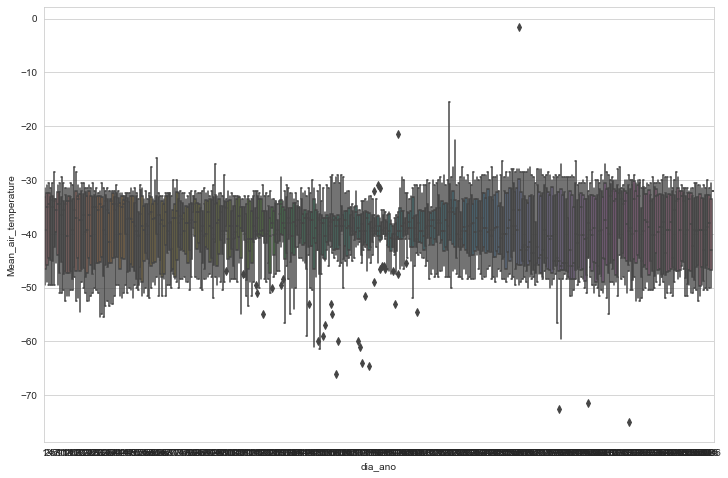

In [328]:
for col in list(train.columns[-5:]) :
    if col != 'Mean_air_temperature':
        plt.figure(figsize = (12,8))
        sns.boxplot(data = train, y = 'Mean_air_temperature', x = col)
        plt.show() 

In [329]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2495 entries, 2020-01-01 to 2012-08-07
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   max_ground_temp(°C)     2495 non-null   Int32  
 1   min_ground_temp(°C)     2495 non-null   Int32  
 2   mean_pressure(Pa)       2495 non-null   Int32  
 3   Mean_air_temperature    2495 non-null   Float64
 4   UV_Radiation_high       2495 non-null   int32  
 5   UV_Radiation_low        2495 non-null   int32  
 6   UV_Radiation_moderate   2495 non-null   int32  
 7   UV_Radiation_very_high  2495 non-null   int32  
 8   dia_semana              2495 non-null   int32  
 9   quarter                 2495 non-null   int32  
 10  mes                     2495 non-null   int32  
 11  ano                     2495 non-null   int32  
 12  dia_ano                 2495 non-null   int32  
dtypes: Float64(1), Int32(3), int32(9)
memory usage: 165.7 KB


In [330]:
cols_dias = train.columns[-5:]

In [331]:
x_train = train[cols_dias]
y_train = train['Mean_air_temperature']

x_test = test[cols_dias]
y_test = test['Mean_air_temperature']

In [332]:
x_train.shape, x_test.shape

((2495, 5), (702, 5))

In [333]:
x_train

,dia_semana,quarter,mes,ano,dia_ano
Data_Terra,,,,,
2020-01-01,2,1,1,2020,1
2019-12-31,1,4,12,2019,365
2019-12-30,0,4,12,2019,364
2019-12-29,6,4,12,2019,363
2019-12-28,5,4,12,2019,362
...,...,...,...,...,...
2012-08-18,5,3,8,2012,231
2012-08-17,4,3,8,2012,230
2012-08-16,3,3,8,2012,229


In [334]:
rg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50)
rg.fit(x_train, y_train, verbose=True)


[17:40:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(early_stopping_rounds=50, n_estimators=1000)

In [335]:
y_pred =rg.predict(x_test)

Let's take a look at the result

In [336]:

mse = mean_squared_error(y_pred, y_test)
print(mse)

181.40294393663882


In [337]:
y_pred = pd.DataFrame(y_pred, index = y_test.index)

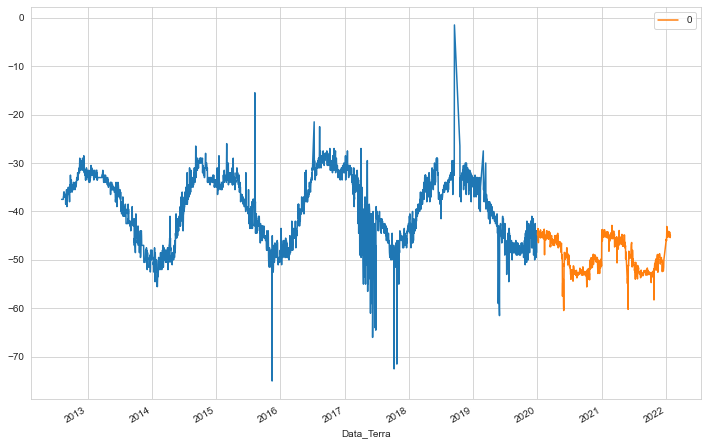

In [338]:
fig, ax = plt.subplots(figsize=(12, 8))
y_train.plot(ax = ax)
y_pred.plot(ax = ax)
plt.show()

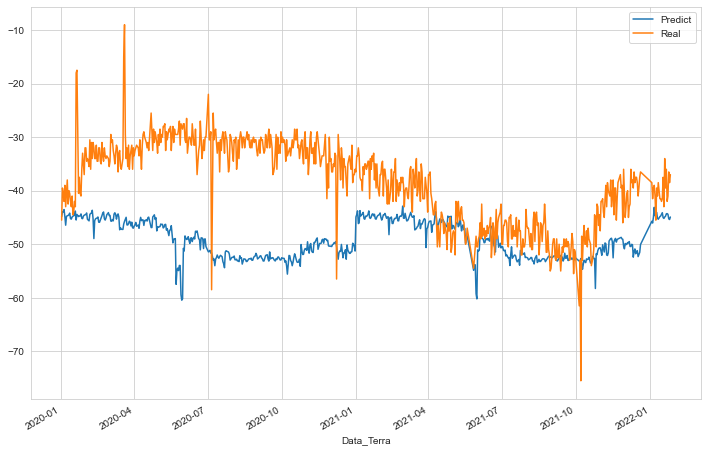

In [339]:
fig, ax = plt.subplots(figsize=(12, 8))
y_pred.plot(ax = ax)
y_test.plot(ax = ax)
ax.legend(['Predict', 'Real'])
plt.show()

### Pressure Prediction

In [340]:
x_train = train[cols_dias]
y_train = train['mean_pressure(Pa)']

x_test = test[cols_dias]
y_test = test['mean_pressure(Pa)']

x_train = x_train.astype('int')
y_train = y_train.astype('int')

x_test = x_test.astype('int')
y_test = y_test.astype('int')


rg = xgb.XGBRegressor(n_estimators=1000)
rg.fit(x_train, y_train, verbose=True)


y_pred =rg.predict(x_test)


mse = mean_squared_error(y_pred, y_test)
print(mse)


y_pred = pd.DataFrame(y_pred, index = y_test.index)

[17:40:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2524.5586165772256


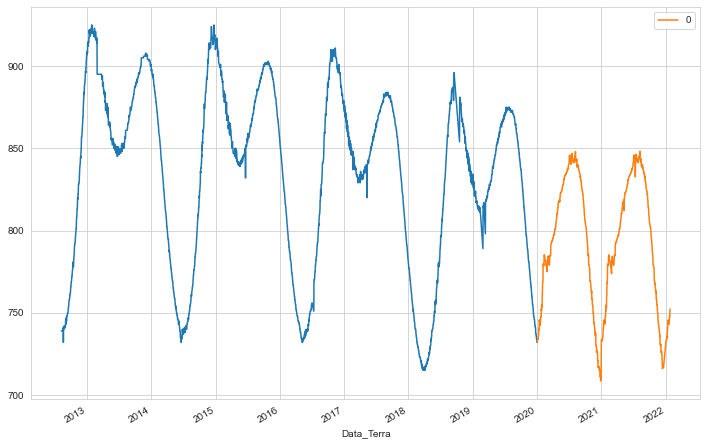

In [341]:
fig, ax = plt.subplots(figsize=(12, 8))
y_train.plot(ax = ax)
y_pred.plot(ax = ax)
plt.show()

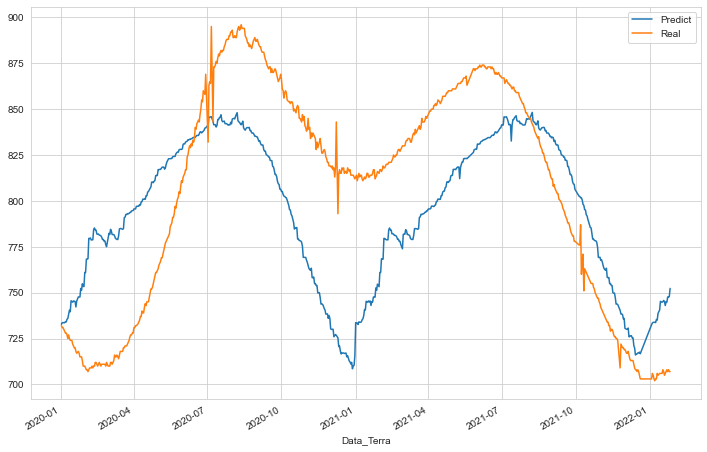

In [342]:
fig, ax = plt.subplots(figsize=(12, 8))
y_pred.plot(ax = ax)
y_test.plot(ax = ax)
ax.legend(['Predict', 'Real'])
plt.show()

## Grid Search

Ok! We noticed that for different targets different approachs are better. Let's try to optimize the XGBRegressor with some grid Search.

In [343]:
from sklearn.model_selection import GridSearchCV

First, lets build a function to help us to select the different aproachs

In [344]:
train.head()

,max_ground_temp(°C),min_ground_temp(°C),mean_pressure(Pa),Mean_air_temperature,UV_Radiation_high,UV_Radiation_low,UV_Radiation_moderate,UV_Radiation_very_high,dia_semana,quarter,mes,ano,dia_ano
Data_Terra,,,,,,,,,,,,,
2020-01-01,-13,-76,732,-46.0,0,0,1,0,2,1,1,2020,1
2019-12-31,-17,-76,734,-44.0,0,0,1,0,1,4,12,2019,365
2019-12-30,-20,-77,734,-45.5,0,0,1,0,0,4,12,2019,364
2019-12-29,-17,-76,735,-45.0,0,0,1,0,6,4,12,2019,363
2019-12-28,-18,-76,736,-45.5,0,0,1,0,5,4,12,2019,362


### Temperature

In [345]:
cols = ['max_ground_temp(°C)', 'min_ground_temp(°C)', 'mean_pressure(Pa)', 'UV_Radiation_high', 'UV_Radiation_low', 'UV_Radiation_moderate',  'UV_Radiation_very_high']
target = ['Mean_air_temperature']


x_train = train[cols]
y_train = train['Mean_air_temperature']


x_test = test[cols]
y_test = test['Mean_air_temperature']


x_train = x_train.astype('int')
y_train = y_train.astype('int')


x_test = x_test.astype('int')
y_test = y_test.astype('int')


In [346]:
GD = {'n_estimators': [100, 500, 1000, 2000, 3000],
      'max_depth': [5,10,15,20],
      'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

In [347]:
rg = xgb.XGBRegressor()
clf = GridSearchCV(rg, GD, n_jobs=-1, cv = 2)

clf.fit(x_train, y_train, verbose=True)


[17:41:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 500, 1000, 2000, 3000]})

[17:41:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
15.339774707142722


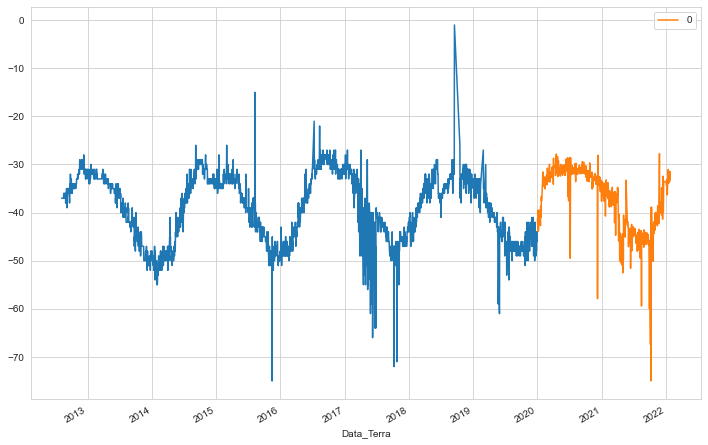

In [348]:
bp = clf.best_params_
rg = xgb.XGBRegressor(**bp)
rg.fit(x_train, y_train)

y_pred =rg.predict(x_test)
mse = mean_squared_error(y_pred, y_test)
print(mse)
y_pred = pd.DataFrame(y_pred, index = y_test.index)

fig, ax = plt.subplots(figsize=(12, 8))
y_train.plot(ax = ax)
y_pred.plot(ax = ax)
plt.show()

### Pressure

In [349]:
x_train = train[cols_dias]
y_train = train['mean_pressure(Pa)']

x_test = test[cols_dias]
y_test = test['mean_pressure(Pa)']

x_train = x_train.astype('int')
y_train = y_train.astype('int')

x_test = x_test.astype('int')
y_test = y_test.astype('int')


In [350]:
rg = xgb.XGBRegressor()
clf = GridSearchCV(rg, GD, n_jobs=-1, cv = 2)

clf.fit(x_train, y_train, verbose=True)


[17:42:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 500, 1000, 2000, 3000]})

In [351]:
bp

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}

[17:42:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2303.7075637112453


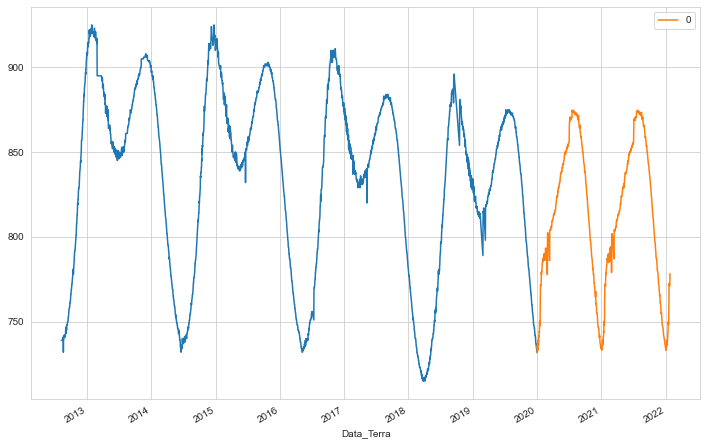

In [352]:
bp = clf.best_params_
rg = xgb.XGBRegressor(**bp)
rg.fit(x_train, y_train)

y_pred =rg.predict(x_test)
mse = mean_squared_error(y_pred, y_test)
print(mse)
y_pred = pd.DataFrame(y_pred, index = y_test.index)

fig, ax = plt.subplots(figsize=(12, 8))
y_train.plot(ax = ax)
y_pred.plot(ax = ax)
plt.show()